In [1]:
# Librerias
#!pip install shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import re
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from sklearn.cluster import KMeans
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from imblearn.over_sampling import SMOTE

from sklearn.dummy import DummyClassifier

import shap

### Analisis inicial

In [2]:
pronostico = pd.read_csv("weatherAUS.csv")

In [3]:
pronostico.info() # 145460

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

1- Date: La fecha en la que se registró.

2- Location: La ciudad en Australia.

3- MinTemp: Temperatura mínima registrada ese día (en grados).

4- MaxTemp: Temperatura máxima registrada ese día (en grados).

5- Rainfall: Cantidad de lluvia registrada ese día (en mm).

6- Evaporation: Cantidad de agua evaporada ese día (en mm).

7- Sunshine: Número de horas de sol.

8- WindGustDir: Dirección del viento durante la ráfaga más fuerte.

9- WindGustSpeed: Velocidad de la ráfaga de viento más fuerte (en km/h).

10- WindDir9am: Dirección del viento a las 9 de la mañana.

11- WindDir3pm: Dirección del viento a las 3 de la tarde.

12- WindSpeed9am: Velocidad del viento a las 9 de la mañana (en km/h).

13- WindSpeed3pm: Velocidad del viento a las 3 de la tarde (en km/h).

14- Humidity9am: Porcentaje de humedad relativa a las 9 de la mañana (en %).

15- Humidity3pm: Porcentaje de humedad relativa a las 3 de la tarde (en %).

16- Pressure9am: Presión atmosférica a las 9 de la mañana (en hPa).

17- Pressure3pm: Presión atmosférica a las 3 de la tarde (en hPa).

18- Cloud9am: Cobertura de nubes a las 9 de la mañana (en oktas, de 0 a 8).

19- Cloud3pm: Cobertura de nubes a las 3 de la tarde (en oktas, de 0 a 8).

20- Temp9am: Temperatura a las 9 de la mañana (en grados).

21- Temp3pm: Temperatura a las 3 de la tarde (en grados).

22- RainToday: Indica si llovió hoy.

23- RainTomorrow: Variable objetivo que indica si lloverá al día siguiente.

In [4]:
pronostico["Date"] = pd.to_datetime(pronostico["Date"])

### Creacion de columnas nuevas

#### Creacion de columnas de tiempo y categoricas como estacion del año y simplificación de la direccion del viento

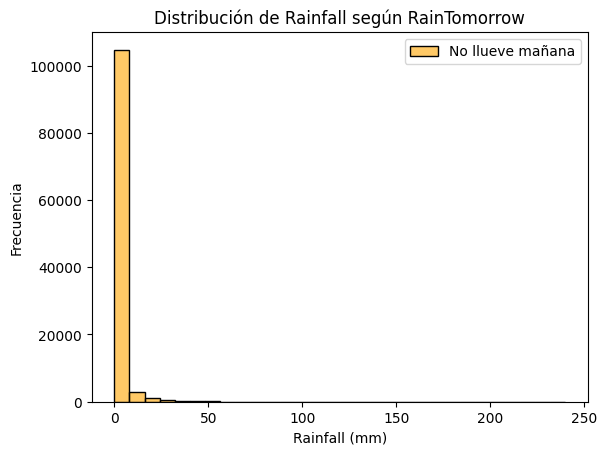

In [5]:
sns.histplot(data=pronostico[pronostico['RainTomorrow'] == "No"],
             x="Rainfall", color="orange", label="No llueve mañana", bins=30, alpha=0.6)
plt.title("Distribución de Rainfall según RainTomorrow")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

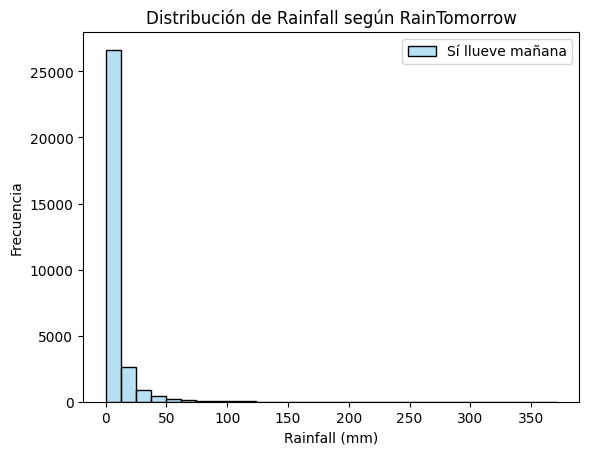

In [6]:
sns.histplot(data=pronostico[pronostico["RainTomorrow"] == "Yes"],
             x="Rainfall", color="skyblue", label="Sí llueve mañana", bins=30, alpha=0.6)

plt.title("Distribución de Rainfall según RainTomorrow")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

La variable Rainfall, hay que categorizarla, ya que tiene demasiados valores cercanos a 0, donde puede influir a la hora del modelo

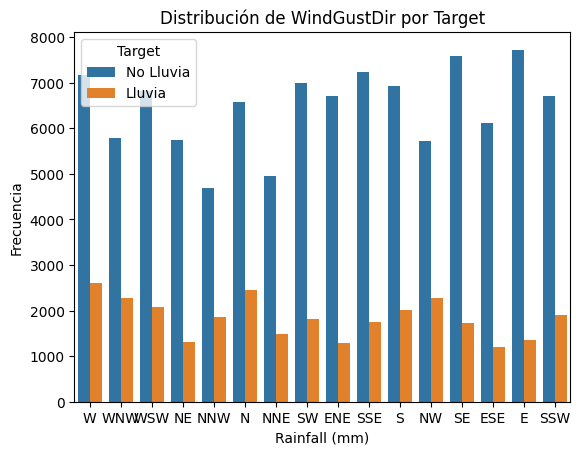

In [7]:
sns.countplot(
    data=pronostico,
    x="WindGustDir",
    hue="RainTomorrow"
)

plt.title("Distribución de WindGustDir por Target")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Frecuencia")
plt.legend(title="Target", labels=["No Lluvia", "Lluvia"])
plt.show()

Aca podemos simplificar la variable de direccion de viento, llevandolas a N, E, O, S, para simplifacar solo en 4 direcciones

In [8]:
# Creamos variables de fecha, para poder mejorar el modelo.

pronostico["dia"] = pronostico["Date"].dt.day
pronostico["mes"] = pronostico["Date"].dt.month
pronostico["año"] = pronostico["Date"].dt.year

In [9]:
def categorizar_rainfall(mm):
    """
    Categorizamos la cantidad de lluvia en mm en diferentes niveles.
    Args:
        mm (float): Cantidad de lluvia en mm.
    Returns:
        str: Categoría de lluvia.
    """
    if mm == 0:
        return 'Ninguna'
    elif mm < 2.5:
        return 'Leve'
    elif mm < 10:
        return 'Moderada'
    else:
        return 'Fuerte'

In [10]:
def simplify_wind_direction(dir):
    """
    Simplifica la dirección del viento a cardinales.
    Args:
        dir (str): Dirección del viento original.
    Returns:
        str: Dirección simplificada (N: Norte, S: Sur, E: Este, O: Oeste, C: Calma).
    """
    if dir in ['N', 'NNE', 'NNW']:
        return 'N'
    elif dir in ['S', 'SSE', 'SSW']:
        return 'S'
    elif dir in ['E', 'ENE', 'ESE']:
        return 'E'
    elif dir in ['W', 'WNW', 'WSW']:
        return 'O'
    else:
        return 'C'

In [11]:
def obtener_estacion_australia(mes, dia):
    """
    Obtenemos la estación del año en Australia según el mes y el día.
    Args:
        mes (int): Mes del año (1-12).
        dia (int): Día del mes (1-31).
    Returns:
        str: Estación del año ('verano', 'otoño', 'invierno', 'primavera').
    """
    if (mes == 12 and dia >= 21) or mes in [1, 2] or (mes == 3 and dia < 21):
        return 'verano'
    elif (mes == 3 and dia >= 21) or mes in [4, 5] or (mes == 6 and dia < 21):
        return 'otoño'
    elif (mes == 6 and dia >= 21) or mes in [7, 8] or (mes == 9 and dia < 21):
        return 'invierno'
    elif (mes == 9 and dia >= 21) or mes in [10, 11] or (mes == 12 and dia < 21):
        return 'primavera'

In [12]:
# Creamos variables, estacion, direccion viento y tipo de lluvia para simplificar la informacion del dataset.

pronostico['Estacion'] = pronostico.apply(lambda row: obtener_estacion_australia(row['mes'], row['dia']), axis=1)
pronostico['Direccion_viento'] = pronostico['WindGustDir'].apply(simplify_wind_direction)
pronostico['WindDir9am'] = pronostico['WindDir9am'].apply(simplify_wind_direction)
pronostico['WindDir3pm'] = pronostico['WindDir3pm'].apply(simplify_wind_direction)
pronostico['Tipo_lluvia'] = pronostico['Rainfall'].apply(categorizar_rainfall) # Consultar si nos quedamos con esta, o con Rainfall

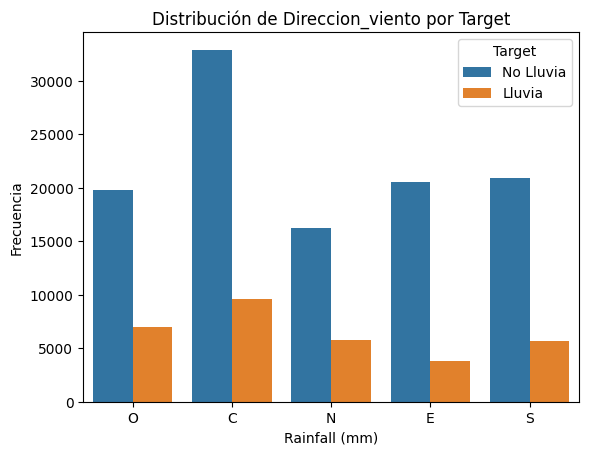

In [13]:
sns.countplot(
    data=pronostico,
    x="Direccion_viento",
    hue="RainTomorrow"
)

plt.title("Distribución de Direccion_viento por Target")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Frecuencia")
plt.legend(title="Target", labels=["No Lluvia", "Lluvia"])
plt.show()

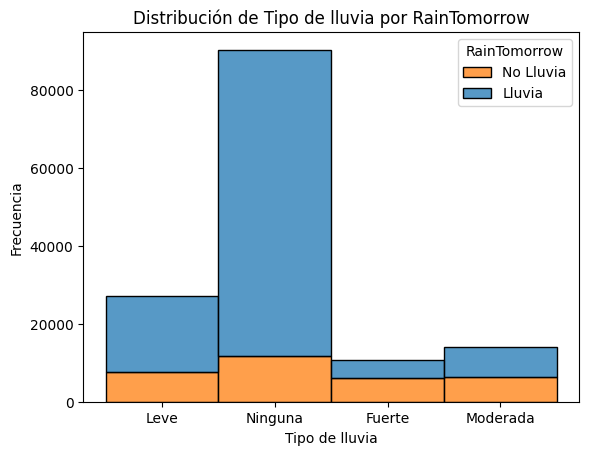

In [14]:
sns.histplot(data=pronostico, x="Tipo_lluvia", hue="RainTomorrow", multiple="stack", bins=30)
plt.title("Distribución de Tipo de lluvia por RainTomorrow")
plt.xlabel("Tipo de lluvia")
plt.ylabel("Frecuencia")
plt.legend(title="RainTomorrow", labels=["No Lluvia", "Lluvia"])
plt.show()

Esto es muchisimo mejor, a la hora de visualizar el tipo de lluvia y la dirección de viento, al simplifarlo queda muchisimo mejor a la hora de utilizarlos en el modelo

#### Creacion de regiones

In [15]:
def formatear_ciudad(nombre):
    """
    Insertar espacios antes de letras mayúsculas intermedias (excepto al principio)
    Args:
        nombre (str): Nombre de la ciudad.
    Returns:
        str: Nombre de la ciudad formateado.
    """
    return re.sub(r'(?<!^)(?=[A-Z])', ' ', nombre).strip()

In [16]:
def obtener_coordenadas(ciudades):
    """
    Recibe una lista o Serie de nombres de ciudades en Australia y devuelve un DataFrame con sus coordenadas geográficas.
    Args:
        ciudades (list or pd.Series): Lista o Serie de nombres de ciudades.
    Returns:
        pd.DataFrame: DataFrame con las ciudades y sus coordenadas (latitud y longitud).
    """
    geolocator = Nominatim(user_agent="geoapi")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

    excepciones = {
        'Pearce R A A F': 'RAAF Base Pearce, Australia'
    }

    datos = []
    for ciudad in ciudades:
        try:
            if ciudad in excepciones:
                loc = geocode(excepciones[ciudad], timeout=10)
            else:
                loc = geocode(f"{ciudad}, Australia", timeout=10)
            if loc:
                datos.append({'ciudad': ciudad, 'latitud': loc.latitude, 'longitud': loc.longitude})
            else:
                datos.append({'ciudad': ciudad, 'latitud': None, 'longitud': None})
        except:
            datos.append({'ciudad': ciudad, 'latitud': None, 'longitud': None})

    return pd.DataFrame(datos)

In [17]:
# Creamos una lista de ciudades, y obtenemos sus coordenadas.
ciudades = pronostico['Location'].unique()
ciudades = [formatear_ciudad(ciudad) for ciudad in ciudades]
ciudades = obtener_coordenadas(ciudades)

Creamos las variables de Latitud y Longitud, y con dichos datos, utilizamos para obtener por el codo, cual es el mejor numero de cluster para subdividir en regiones.

C:\Users\marya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\marya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^

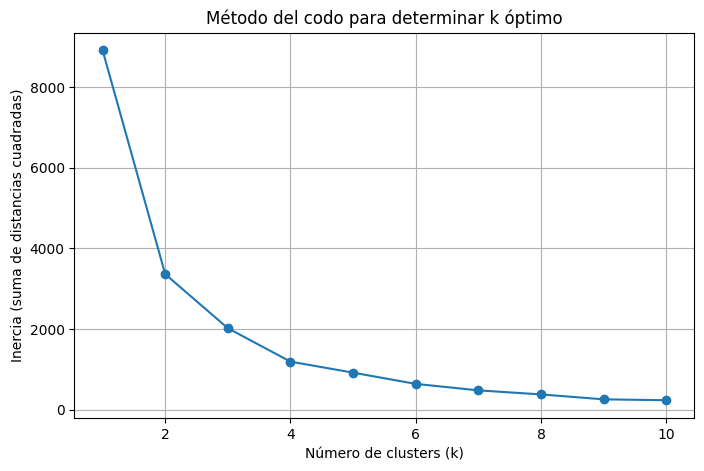

In [18]:
inertias = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(ciudades[['latitud', 'longitud']])
    inertias.append(kmeans.inertia_)

# Graficar el resultado
plt.figure(figsize=(8,5))
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (suma de distancias cuadradas)')
plt.title('Método del codo para determinar k óptimo')
plt.grid(True)
plt.show()

A partir del grafico, se puede apreciar que el optimo es con 4, ya que despues de ese número deja de cambiar tan drasticamente

##### Grafico de las ciudades

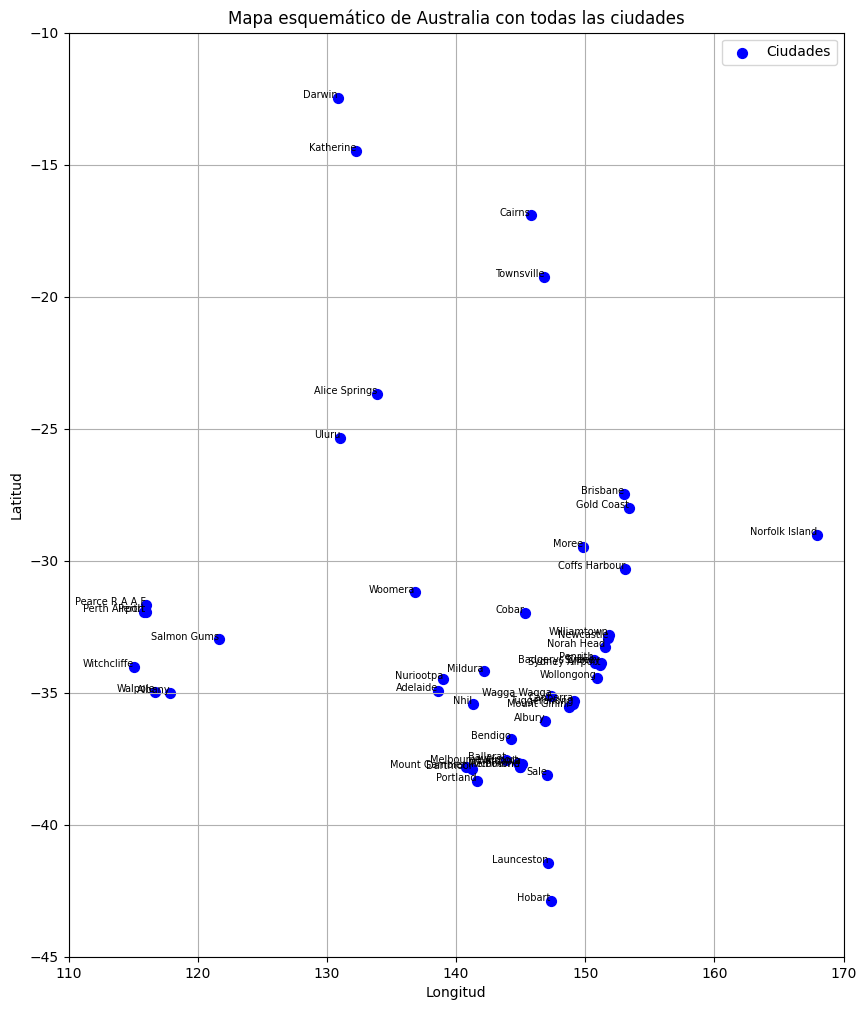

In [19]:
# Creamos un diccionario con la ciudad, y su longitud, para poder graficar.
city_coords = {item[0]: (item[1], item[2]) for item in ciudades.values}
plt.figure(figsize=(10, 12))
plt.scatter(
    [lon for lat, lon in city_coords.values()],
    [lat for lat, lon in city_coords.values()],
    s=50, c='blue', label='Ciudades'
)
for city, (lat, lon) in city_coords.items():
    plt.text(lon, lat, city, fontsize=7, ha='right')

plt.title('Mapa esquemático de Australia con todas las ciudades')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.xlim(110, 170)
plt.ylim(-45, -10)
plt.grid(True)
plt.legend()
plt.show()

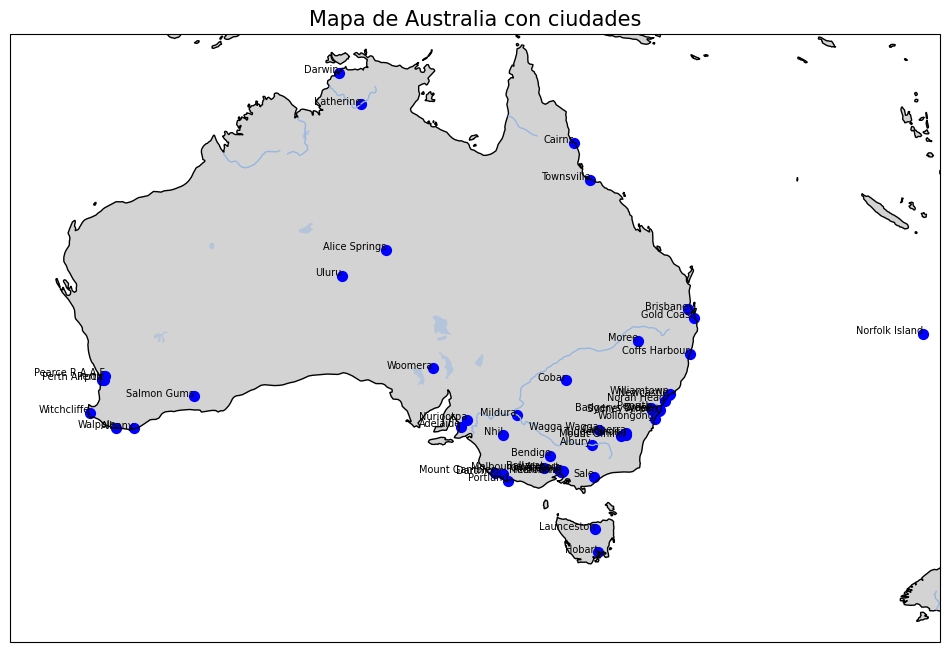

In [20]:
# Mapa hecho con cartopy
plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())  # Proyección para coordenadas geográficas
ax.set_extent([110, 169, -45, -10])  # Limites del mapa (longitud mínima, máxima, latitud mínima, máxima)

# Agregar detalles al mapa
ax.add_feature(cfeature.LAND, facecolor='lightgrey')  # Color de la tierra
ax.add_feature(cfeature.COASTLINE)  # Costas
ax.add_feature(cfeature.BORDERS, linestyle=':')  # Fronteras
ax.add_feature(cfeature.LAKES, alpha=0.5)  # Lagos
ax.add_feature(cfeature.RIVERS)  # Ríos

for city, (lat, lon) in city_coords.items():
    plt.scatter(lon, lat, s=50, c='blue', label='Ciudades', transform=ccrs.PlateCarree())
    plt.text(lon, lat, city, fontsize=7, ha='right', transform=ccrs.PlateCarree())

plt.title('Mapa de Australia con ciudades', fontsize=15)
plt.show()

##### Agrupamos por ciudades

In [21]:
k_optimo = 4 # segun el grafico del codo

nombres_regiones = {
    0: 'Norte',
    1: 'Sur',
    2: 'Este',
    3: 'Oeste'
}

kmeans = KMeans(n_clusters=k_optimo, random_state=0)
ciudades['Region'] = kmeans.fit_predict(ciudades[['latitud', 'longitud']])

pronostico['Location'] = pronostico['Location'].apply(lambda x: formatear_ciudad(x))
pronostico = pronostico.merge(ciudades[['ciudad', 'Region']], left_on='Location', right_on='ciudad', how='left')
pronostico.drop(columns=['ciudad'], inplace=True)
pronostico['Region'] = pronostico['Region'].map(nombres_regiones)

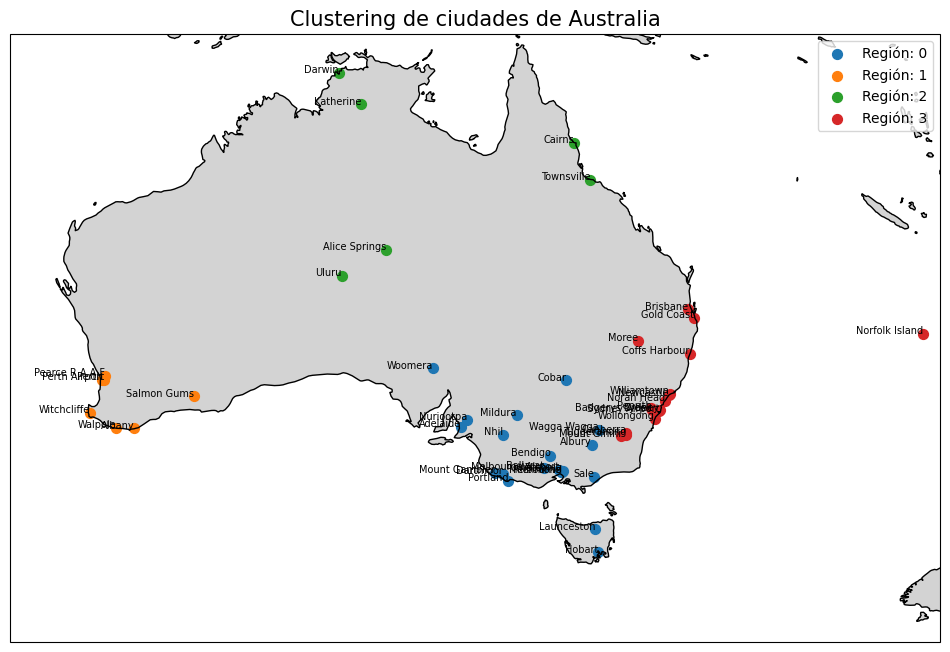

In [22]:
# Configuración del mapa
plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([110, 169, -45, -10])  # Extensión del mapa (longitudes y latitudes de Australia)

# Agregar características al mapa
ax.add_feature(cfeature.LAND, facecolor='lightgrey')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Graficar las ciudades según la región
for region_name, region_id in nombres_regiones.items():
    region_data = ciudades[ciudades['Region'] == region_name]
    plt.scatter(
        region_data['longitud'],
        region_data['latitud'],
        label=f'Región: {region_name}',
        s=50,
        transform=ccrs.PlateCarree()
    )

# Agregar etiquetas de las ciudades
for _, row in ciudades.iterrows():
    plt.text(
        row['longitud'],
        row['latitud'],
        row['ciudad'],
        fontsize=7,
        ha='right',
        transform=ccrs.PlateCarree()
    )

# Configuración del gráfico
plt.title('Clustering de ciudades de Australia', fontsize=15)
plt.legend()
plt.show()


In [23]:
# Verificamos que no haya nulos en la columna RainTomorrow.
print(f"{pronostico['RainTomorrow'].isna().sum()} nulos en nuestra columna objetivo")

#Eliminamos los nulos
pronostico = pronostico.dropna(subset=["RainTomorrow"])

3267 nulos en nuestra columna objetivo


### Division del dataset

In [24]:
# Eliminamos las columnas Date y RainTomorrow, una es la que vamos a predecir y la otra es la no nos sirve para el modelo.
X = pronostico.drop(labels =['Date','RainTomorrow', 'Location', 'WindGustDir'], axis = 1)
y = pronostico['RainTomorrow']

In [25]:
# Ordenar los datos por fecha
pronostico = pronostico.sort_values(by='Date')

# Determinar el índice de corte para dividir en entrenamiento y prueba
train_size = int(len(pronostico) * 0.8)

# Dividir en conjuntos de entrenamiento y prueba
X_train = pronostico.iloc[:train_size].drop(['Date', 'RainTomorrow'], axis=1)
y_train = pronostico.iloc[:train_size]['RainTomorrow']

X_test = pronostico.iloc[train_size:].drop(['Date', 'RainTomorrow'], axis=1)
y_test = pronostico.iloc[train_size:]['RainTomorrow']

### Valores nulos

In [26]:
def calcular_mediana(df : pd.DataFrame, grupo_cols = ['Estacion', 'Region']) -> dict:
    """
    Calcula la mediana de una columna específica en un DataFrame.
    Args:
        df (pd.DataFrame): DataFrame que contiene los datos.
        columna (str): Nombre de la columna para calcular la mediana.
        grupo_cols (list): Lista de columnas por las cuales agrupar los datos antes de calcular la mediana.
    Returns:
        dict: Diccionario con las medianas calculadas para cada grupo.
    """
    medianas = {}
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        medianas[col] = df.groupby(grupo_cols)[col].median()
    return medianas

In [27]:
def calcular_moda (df : pd.DataFrame, grupo_cols = ['Estacion', 'Region']) -> dict:
    """
    Calcula la moda de una columna específica en un DataFrame.
    Args:
        df (pd.DataFrame): DataFrame que contiene los datos.
        columna (str): Nombre de la columna para calcular la moda.
        grupo_cols (list): Lista de columnas por las cuales agrupar los datos antes de calcular la moda.
    Returns:
        dict: Diccionario con las modas de la columna especificada agrupadas por las columnas indicadas.
    """
    modas = {}
    for col in df.select_dtypes(include=['object', 'category']).columns:
        modas[col] = df.groupby(grupo_cols)[col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    return modas

In [28]:
def rellenar_nulos_numericos(df: pd.DataFrame, medianas: dict, grupo_cols=['Estacion', 'Region']) -> pd.DataFrame:
    """
    Rellena los valores nulos numericos del dataframe con la mediana de la columna, por mes y región.
    Args:
        df (pd.DataFrame): DataFrame con los datos meteorológicos.
    Returns:
        pd.DataFrame: DataFrame con los valores nulos rellenados.
    """

    for col, medianas_col in medianas.items():
        def fill_na(row):
            if pd.isna(row[col]):
                key = tuple(row[grupo_cols])
                return medianas_col.get(key, medianas_col.median())
            else:
                return row[col]
        df[col] = df.apply(fill_na, axis=1)
    return df

In [29]:
def rellenar_nulos_categoricos(df: pd.DataFrame,  modas: dict, grupo_cols=['Estacion', 'Region']) -> pd.DataFrame:
    """
    Rellena los valores nulos categoricos del dataframe con la moda de la columna, por mes y por region.
    Args:
        df (pd.DataFrame): DataFrame con los datos meteorológicos.
    Returns:
        pd.DataFrame: DataFrame con los valores nulos rellenados.
    """
    for col, modas_col in modas.items():
        def fill_na(row):
            if pd.isna(row[col]):
                key = tuple(row[grupo_cols])
                # Buscar moda para el grupo, si no existe usar moda global (opcional)
                return modas_col.get(key, modas_col.mode().iloc[0])
            else:
                return row[col]
        df[col] = df.apply(fill_na, axis=1)
    return df

In [30]:
X_train.isna().sum()

Location                0
MinTemp               469
MaxTemp               223
Rainfall             1128
Evaporation         44361
Sunshine            48542
WindGustDir          7735
WindGustSpeed        7675
WindDir9am              0
WindDir3pm              0
WindSpeed9am         1203
WindSpeed3pm         1400
Humidity9am          1476
Humidity3pm          1695
Pressure9am         11069
Pressure3pm         11034
Cloud9am            41346
Cloud3pm            42639
Temp9am               807
Temp3pm               986
RainToday            1128
dia                     0
mes                     0
año                     0
Estacion                0
Direccion_viento        0
Tipo_lluvia             0
Region                  0
dtype: int64

In [31]:
X_train.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,dia,mes,año
count,113285.000000,113531.000000,112626.000000,69393.000000,65212.000000,106079.000000,112551.000000,112354.000000,112278.000000,112059.000000,102685.000000,102720.000000,72408.000000,71115.000000,112947.000000,112768.000000,113754.000000,113754.000000,113754.000000
mean,11.951064,22.959709,2.345608,5.301313,7.588464,40.063641,14.032714,18.685921,68.815271,51.532380,1017.801118,1015.409600,4.330654,4.430106,16.762038,21.479511,15.702815,6.492985,2011.895889
std,6.371251,7.033272,8.491865,3.989902,3.772434,13.623196,8.957718,8.854735,19.048500,20.729464,7.133546,7.061167,2.877291,2.704055,6.440774,6.873108,8.819406,3.377355,2.064803
min,-8.500000,-4.100000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,979.000000,0.000000,0.000000,-6.200000,-5.100000,1.000000,1.000000,2007.000000
25%,7.400000,17.800000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.100000,1010.600000,1.000000,2.000000,12.100000,16.500000,8.000000,4.000000,2010.000000
50%,11.800000,22.300000,0.000000,4.600000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.800000,1015.400000,5.000000,5.000000,16.500000,20.900000,16.000000,7.000000,2012.000000
75%,16.600000,27.900000,0.800000,7.200000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.600000,1020.200000,7.000000,7.000000,21.300000,26.100000,23.000000,9.000000,2014.000000
max,33.900000,48.100000,371.000000,82.400000,14.300000,135.000000,87.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.100000,31.000000,12.000000,2015.000000


In [32]:
medianas = calcular_mediana(X_train)
modas = calcular_moda(X_train)

X_train = rellenar_nulos_numericos(X_train, medianas)
X_train = rellenar_nulos_categoricos(X_train, modas)

X_test = rellenar_nulos_numericos(X_test, medianas)
X_test = rellenar_nulos_categoricos(X_test, modas)


### Graficos

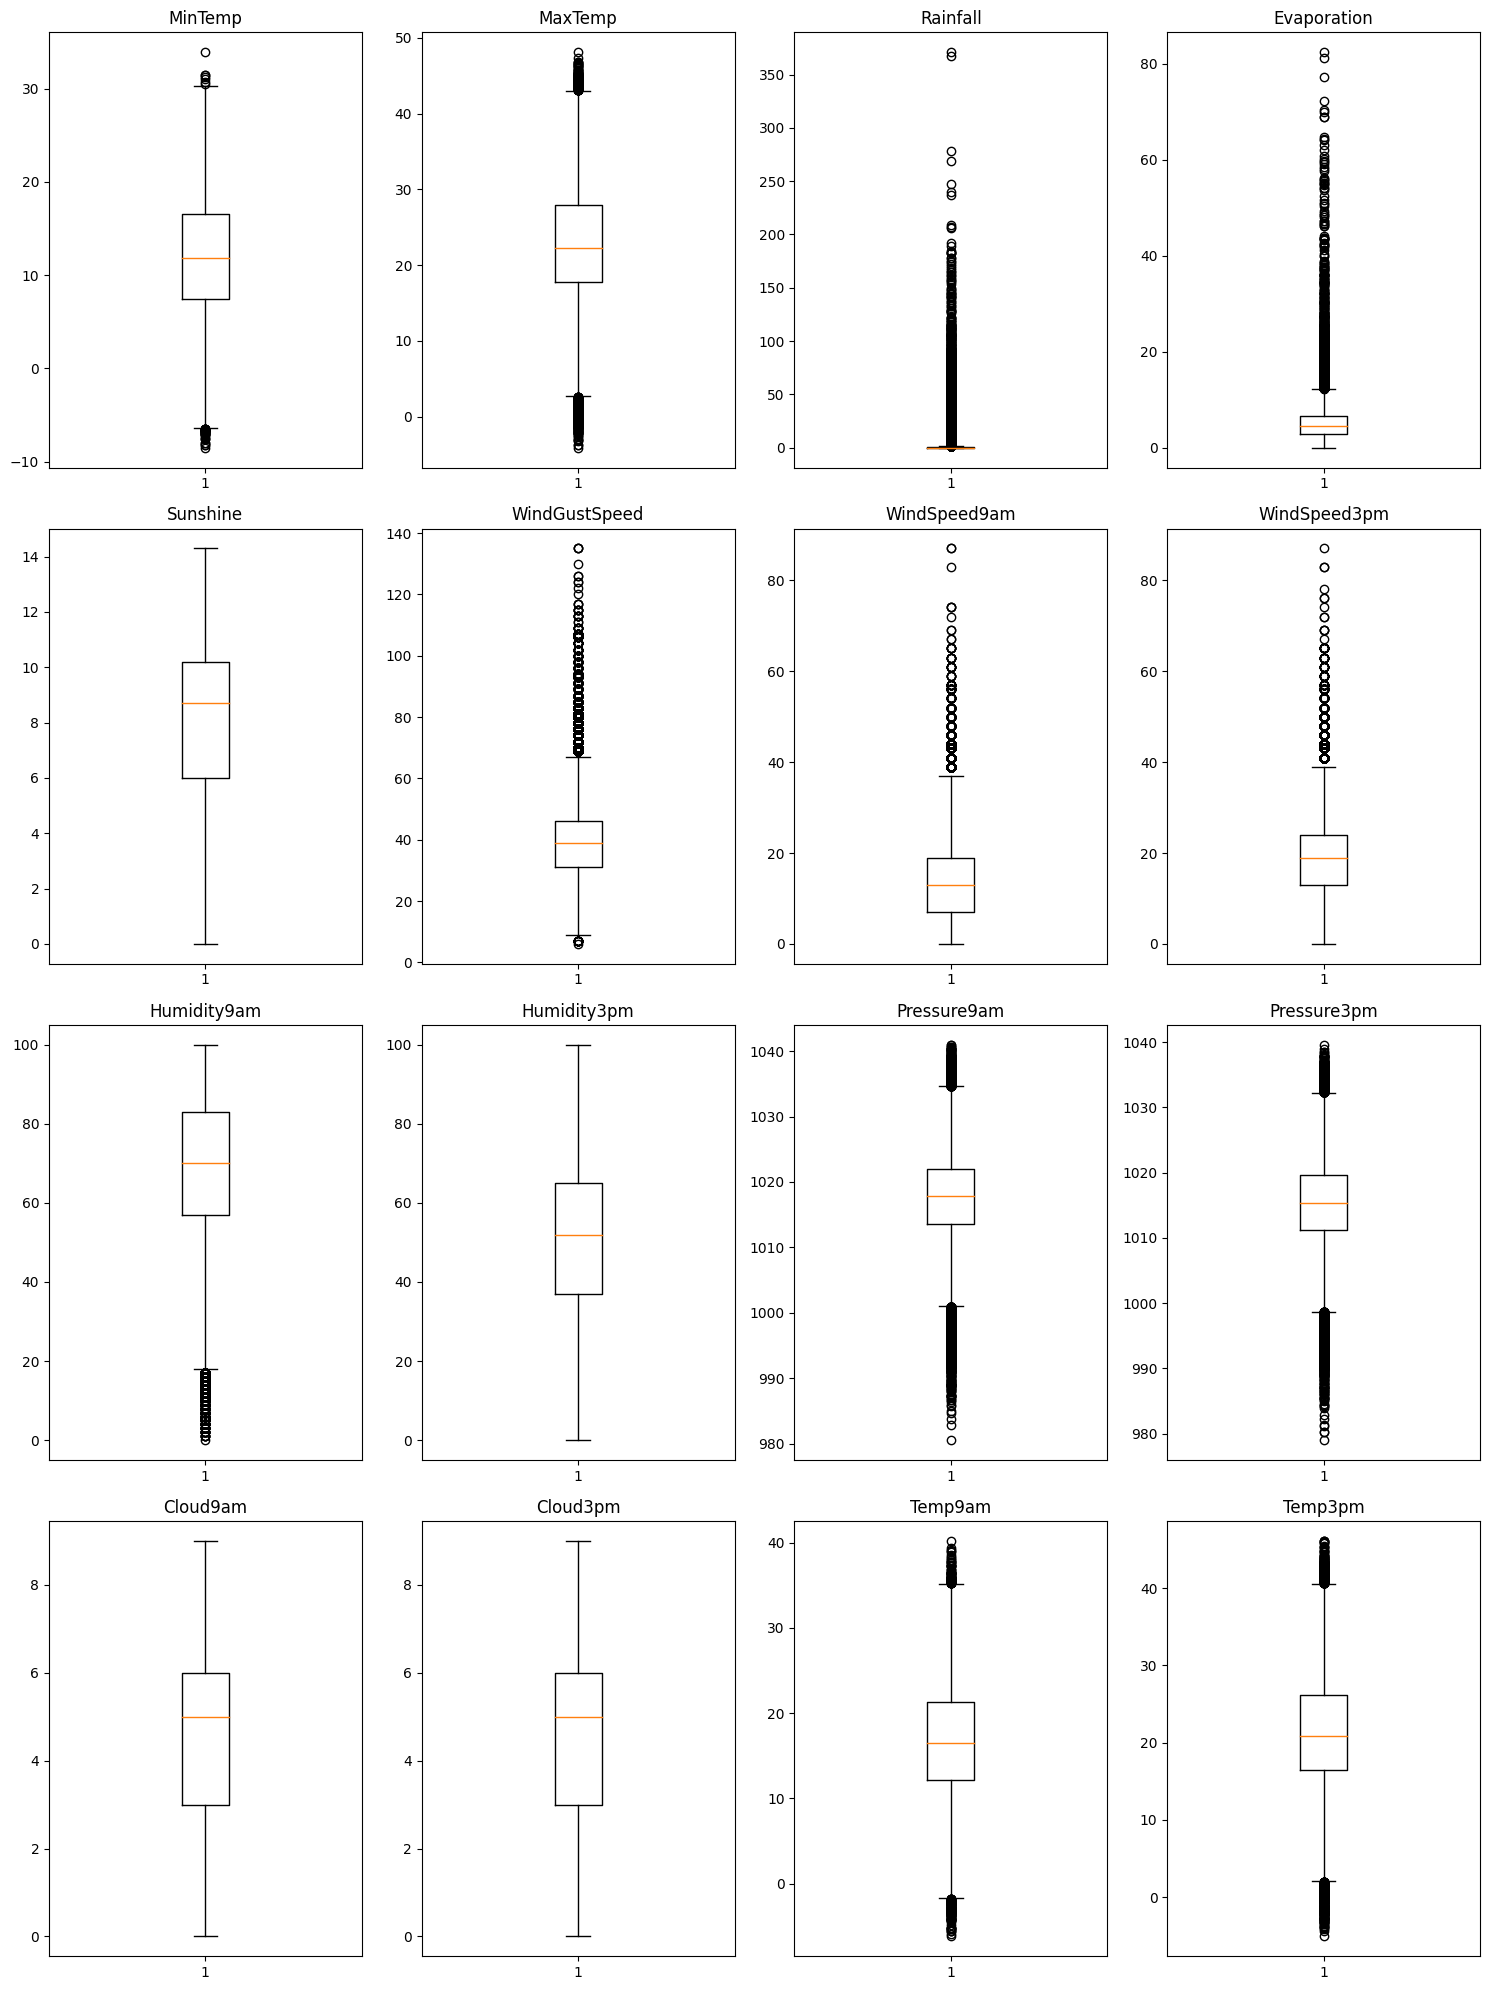

In [33]:
# Boxplots

# Obtenemos las columnas numericos
numericas = list(X_train.select_dtypes(include=['float64', 'int64']).columns)

# Graficamos los boxplot de las columnas numericas
fig, axis = plt.subplots(4, 4, figsize=(15, 20))

# Aplanamos la matriz de subgráficos para facilitar el acceso
axis = axis.flatten()

# Iteramos sobre las columnas numéricas y los subgráficos
for i, columans in enumerate(numericas):
    axis[i].boxplot(X_train[columans])
    axis[i].set_title(columans)

plt.tight_layout()
plt.show()

Se pueden apreciar presencia de valores atipico, pero la mayoria de ellos seria de cuando llueve, y/o relacionadas a otras variables que podrian explicarse. Variables como Evaporation o Rainfall, aparecen que tienen muchisimo valores atipico, pero se pueden explicarse debido a que no siempre llovia.

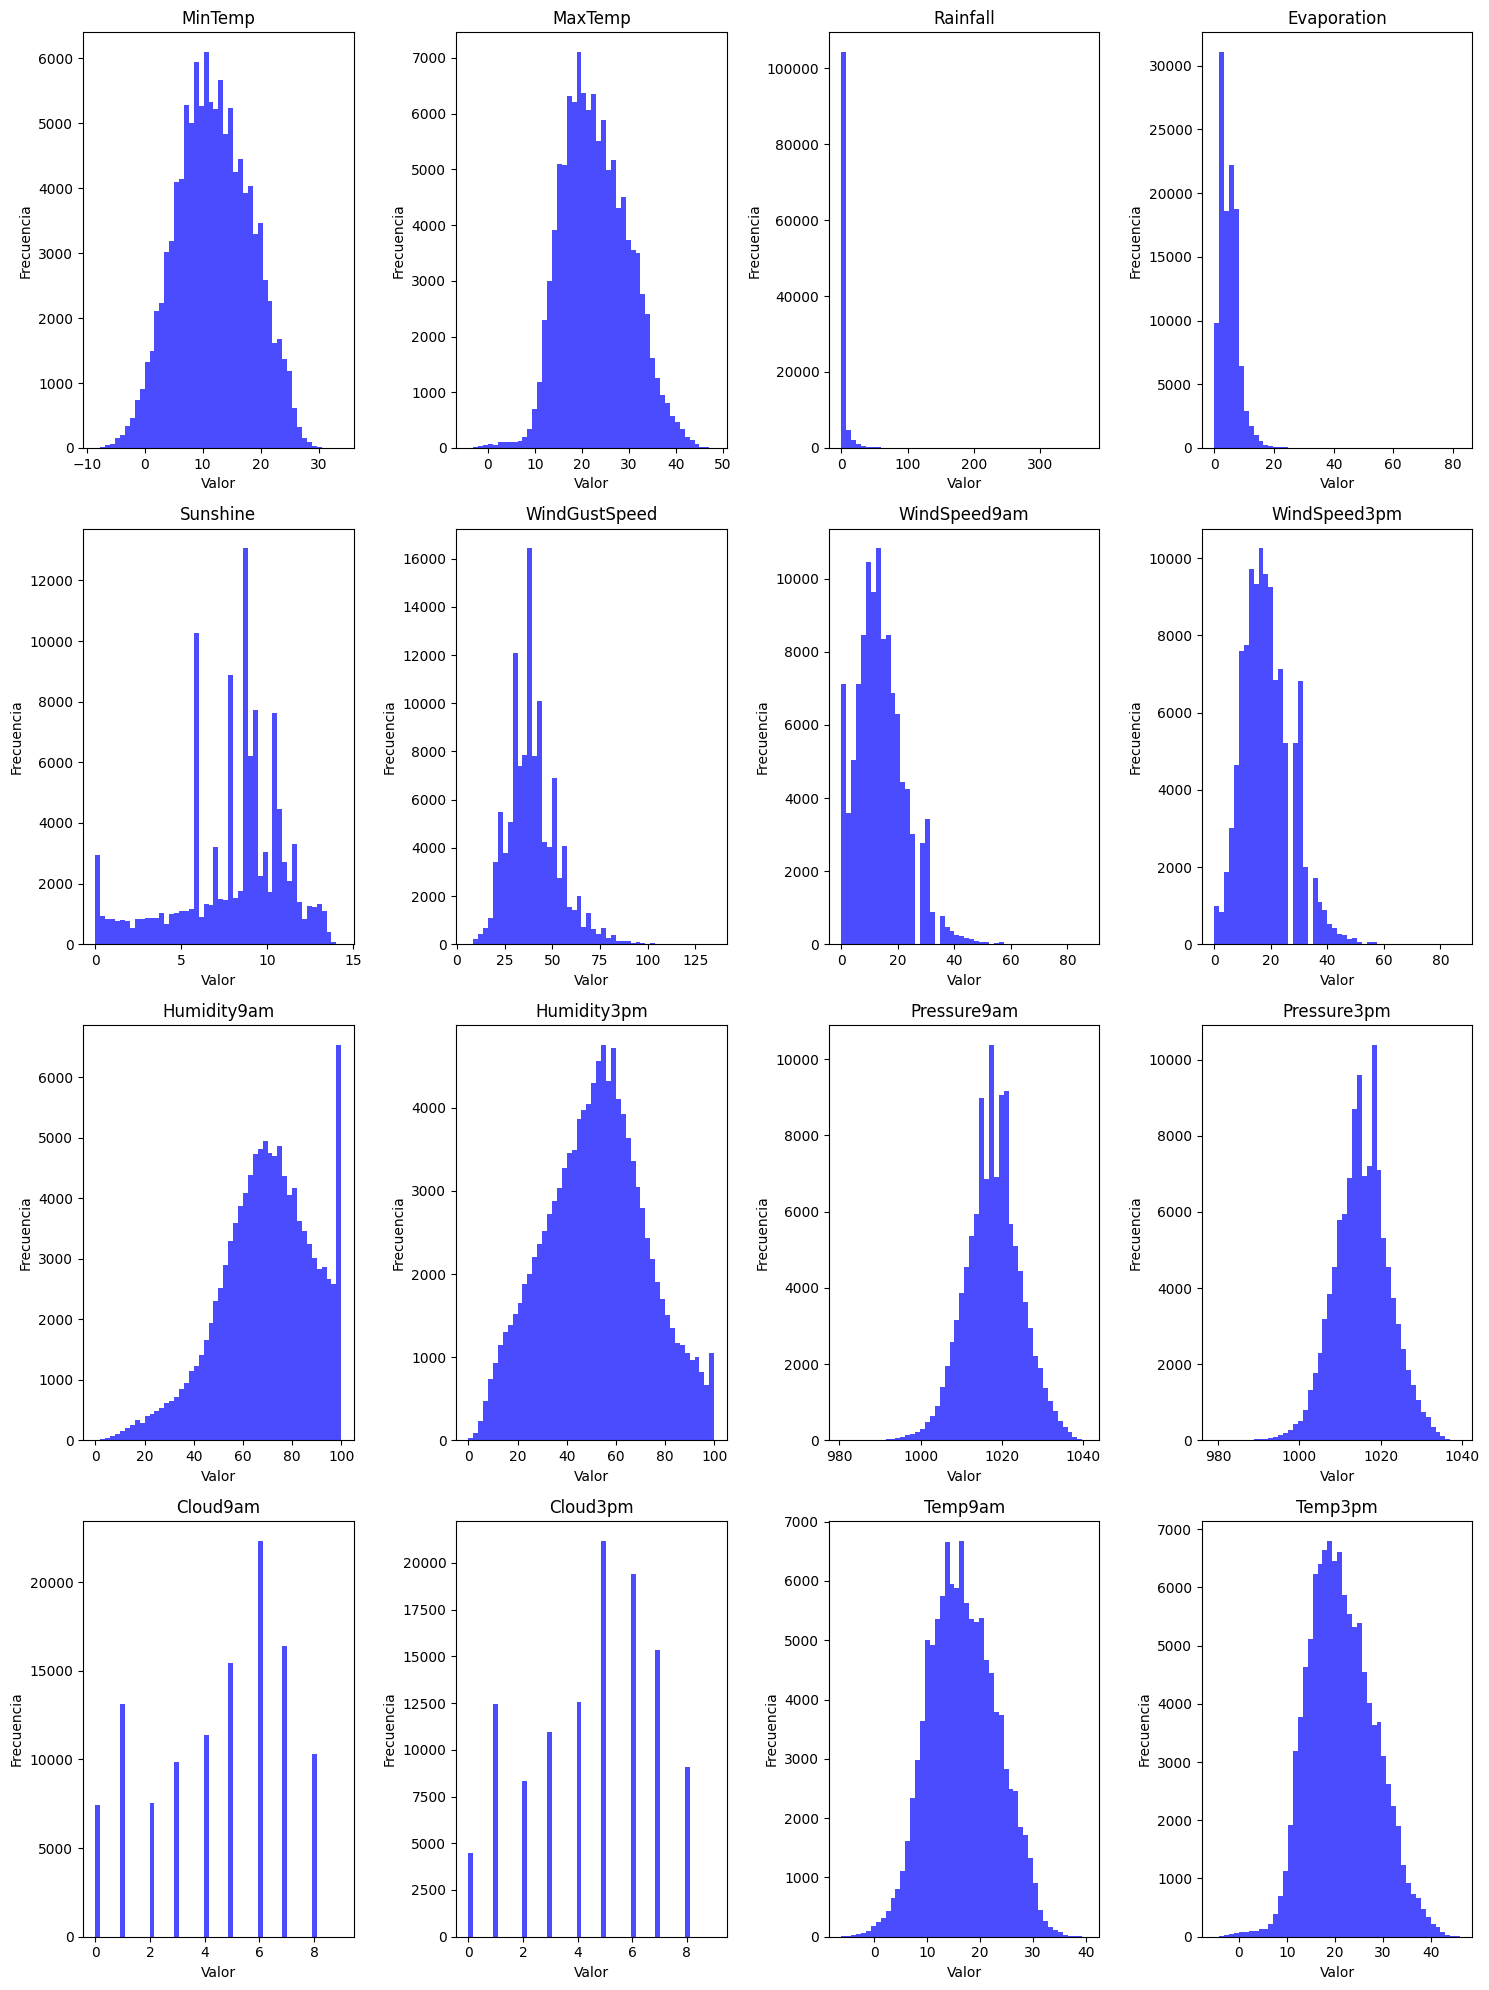

In [34]:
# Histogramas

fig, axis = plt.subplots(4, 4, figsize=(15, 20))

# Aplanamos la matriz de subgráficos para facilitar el acceso
axis = axis.flatten()

# Iteramos sobre las columnas numéricas y los subgráficos

for i, columans in enumerate(numericas):
    axis[i].hist(X_train[columans], bins=50, color='blue', alpha=0.7)
    axis[i].set_title(columans)
    axis[i].set_xlabel('Valor')
    axis[i].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

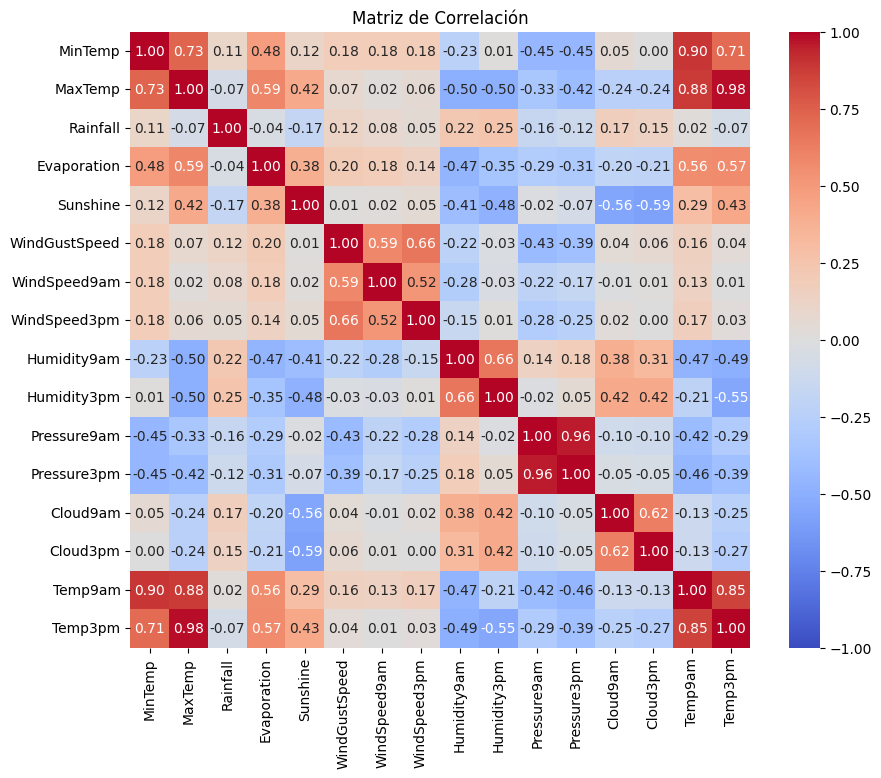

In [35]:
# Matriz de correlación

correlacion = X_train[numericas].corr()

# Visualizamos la matriz de correlación con un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title("Matriz de Correlación")
plt.show()

In [36]:
# Verificamos si la variable target está balanceada
no, si = y_train.value_counts()
total = no + si
print(f"Porcentaje de lluvia: {si/total*100:.2f}%")

Porcentaje de lluvia: 22.44%


Se puede apreciar que se encuentra desbalanciado, con un 22.45% de valores que predicen que va a llover

### Creación de variables dummy

In [37]:
# Codificación de variables categóricas
variables_categoricas = ['Estacion', 'Direccion_viento', 'Tipo_lluvia', 'Region', 'RainToday', 'WindDir9am', 'WindDir3pm']
X_train_cat = pd.get_dummies(X_train[variables_categoricas], drop_first=False)
X_test_cat = pd.get_dummies(X_test[variables_categoricas], drop_first=False)

# Aseguramos que las columnas sean consistentes
X_train_cat, X_test_cat = X_train_cat.align(X_test_cat, join='outer', axis=1, fill_value=0)

### Estandarizacion

In [38]:
numericas = ['MinTemp',
             'MaxTemp',
             'Evaporation', 
             'Sunshine',
             'WindGustSpeed',
             'WindSpeed9am',
             'WindSpeed3pm', 
             'Humidity9am',
             'Humidity3pm',
             'Pressure9am',
             'Pressure3pm',
             'Cloud9am',
             'Cloud3pm',
             'Temp9am',
             'Temp3pm'
             ]

# Estandarización de variables numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numericas])
X_test_scaled = scaler.transform(X_test[numericas])

# Codificación de variables categóricas
variables_categoricas = ['Estacion', 'Direccion_viento', 'Tipo_lluvia', 'Region', 'RainToday', 'WindDir9am', 'WindDir3pm']
X_train_cat = pd.get_dummies(X_train[variables_categoricas], drop_first=False)
X_test_cat = pd.get_dummies(X_test[variables_categoricas], drop_first=False)

# Aseguramos que las columnas sean consistentes
X_train_cat, X_test_cat = X_train_cat.align(X_test_cat, join='outer', axis=1, fill_value=0)

# Convertimos los datos escalados en DataFrames para mantener consistencia con los nombres de columnas
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numericas, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numericas, index=X_test.index)

# Combinación final
X_train_full = pd.concat([X_train_scaled_df, X_train_cat], axis=1)
X_test_final = pd.concat([X_test_scaled_df, X_test_cat], axis=1)

### Balanceo

In [39]:
X_train_final, y_train_final = SMOTE(random_state=42).fit_resample(X_train_full, y_train)

### Entrenamiento del modelo y métricas

In [40]:
# Entrenamos el modelo
modelo = LogisticRegression(random_state=42, max_iter=500)
modelo.fit(X_train_final, y_train_final)

LogisticRegression(max_iter=500, random_state=42)

#### Predicción y matríz de confusión con X_train

              precision    recall  f1-score   support

          No       0.84      0.90      0.87     88224
         Yes       0.89      0.83      0.86     88224

    accuracy                           0.87    176448
   macro avg       0.87      0.87      0.86    176448
weighted avg       0.87      0.87      0.86    176448



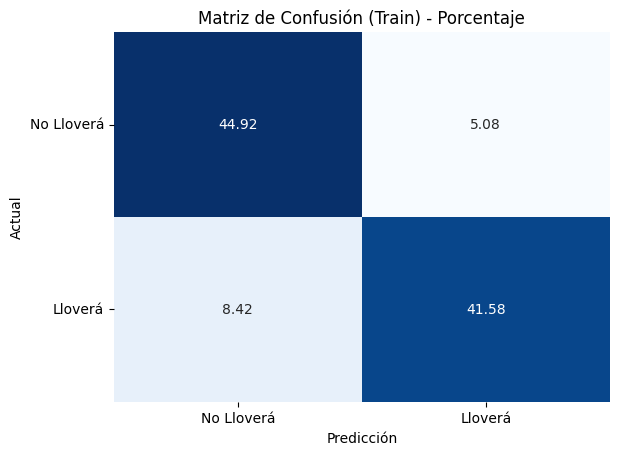

In [41]:
# Generar predicciones para el conjunto de entrenamiento
y_train_pred = modelo.predict(X_train_final)

# Métricas
print(classification_report(y_train_final, y_train_pred))

# Crear la matriz de confusión
conf_matrix_train = confusion_matrix(y_train_final, y_train_pred)

# Convertir los valores en porcentaje
conf_matrix_train_percent = conf_matrix_train / conf_matrix_train.sum() * 100

# Visualizar la matriz de confusión
plt.figure()
sns.heatmap(conf_matrix_train_percent, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.title("Matriz de Confusión (Train) - Porcentaje")
plt.xlabel("Predicción")
plt.ylabel("Actual")
plt.xticks(ticks=[0.5, 1.5], labels=['No Lloverá', 'Lloverá'])
plt.yticks(ticks=[0.5, 1.5], labels=['No Lloverá', 'Lloverá'], rotation=0)
plt.show()


#### Predicción y matríz de confusión con X_test

              precision    recall  f1-score   support

          No       0.88      0.91      0.90     22092
         Yes       0.64      0.58      0.61      6347

    accuracy                           0.83     28439
   macro avg       0.76      0.74      0.75     28439
weighted avg       0.83      0.83      0.83     28439



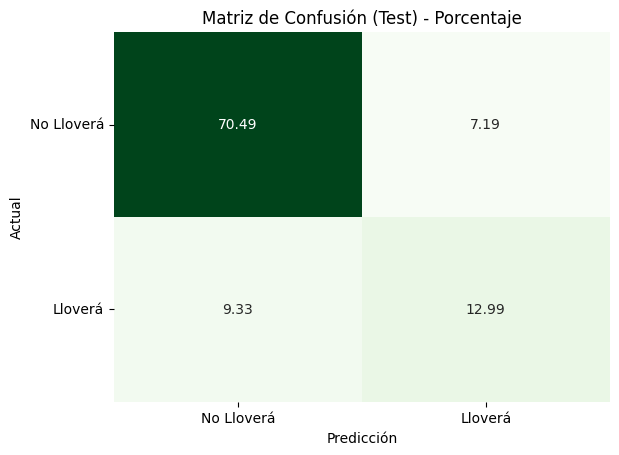

In [42]:
# Predicciones
y_pred = modelo.predict(X_test_final)
y_pred_proba = modelo.predict_proba(X_test_final)[:, 1]

# Métricas básicas
print(classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix_test = confusion_matrix(y_test, y_pred, labels=['No', 'Yes'])
conf_matrix_test_percent = conf_matrix_test / conf_matrix_test.sum() * 100
sns.heatmap(conf_matrix_test_percent, annot=True, fmt=".2f", cmap="Greens", cbar=False)
plt.title("Matriz de Confusión (Test) - Porcentaje")
plt.xlabel("Predicción")
plt.ylabel("Actual")
plt.xticks(ticks=[0.5, 1.5], labels=['No Lloverá', 'Lloverá'])
plt.yticks(ticks=[0.5, 1.5], labels=['No Lloverá', 'Lloverá'], rotation=0)
plt.show()

#### Analisis de falsos positivos y falsos negativos

Falsos Positivos (4.18%) -> Predicción incorrecta de "Lloverá" cuando realmente "No Lloverá"
Si el costo de emitir una alerta falsa es bajo, este nivel de falsos positivos podría ser aceptable.

Falsos Negativos (11.62%) -> Predicción incorrecta de "No Lloverá" cuando realmente "Lloverá".
No tomar precauciones cuando llueve podría tener un impacto mayor, como daños materiales, cancelación de eventos o riesgos para la población.
Este porcentaje es más crítico, especialmente si las lluvias severas son importantes de predecir en el contexto.

#### Curva ROC

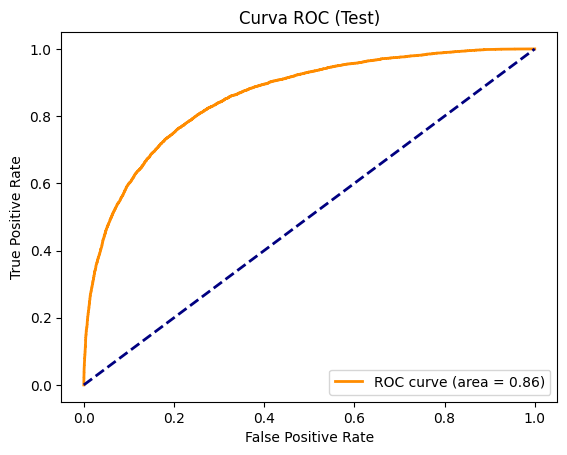

AUC: 0.86
Umbral óptimo: 0.30


In [43]:
# Generar probabilidades de predicción
y_pred_proba_test = modelo.predict_proba(X_test_final)[:, 1]

# Curva ROC para el conjunto de prueba
fpr, tpr, thresholds = roc_curve(y_test.map({'No': 0, 'Yes': 1}), y_pred_proba_test)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC (Test)')
plt.legend(loc="lower right")
plt.show()

# Identificar el umbral óptimo (maximizar TPR - FPR)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"AUC: {roc_auc:.2f}")
print(f"Umbral óptimo: {optimal_threshold:.2f}")


#### Predicción y matríz de confusión con X_test con UMBRAL ÓPTIMO

              precision    recall  f1-score   support

           0       0.92      0.79      0.85     22092
           1       0.51      0.76      0.61      6347

    accuracy                           0.78     28439
   macro avg       0.72      0.78      0.73     28439
weighted avg       0.83      0.78      0.80     28439



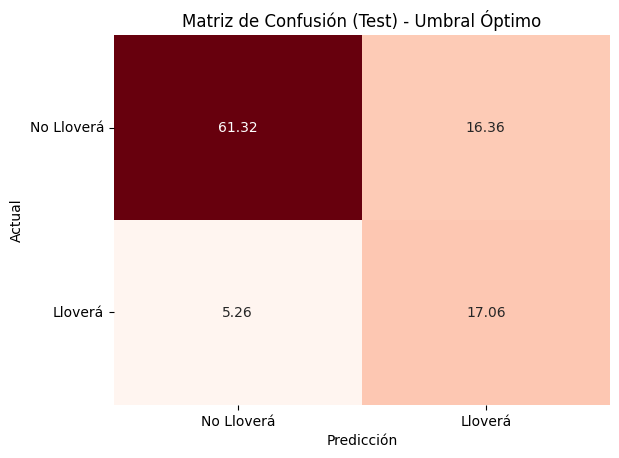

In [44]:
# Usar el umbral óptimo para clasificar
y_pred_optimo = (y_pred_proba_test >= optimal_threshold).astype(int)

# Recalcular métricas con el nuevo umbral
print(classification_report(y_test.map({'No': 0, 'Yes': 1}), y_pred_optimo))

# Calcular la matriz de confusión
conf_matrix_opt = confusion_matrix(y_test.map({'No': 0, 'Yes': 1}), y_pred_optimo)

# Convertir la matriz de confusión a porcentajes
conf_matrix_opt_percent = conf_matrix_opt / conf_matrix_opt.sum() * 100

# Graficar la matriz de confusión
plt.figure()
sns.heatmap(conf_matrix_opt_percent, annot=True, fmt=".2f", cmap="Reds", cbar=False)
plt.title("Matriz de Confusión (Test) - Umbral Óptimo")
plt.xlabel("Predicción")
plt.ylabel("Actual")
plt.xticks(ticks=[0.5, 1.5], labels=['No Lloverá', 'Lloverá'])
plt.yticks(ticks=[0.5, 1.5], labels=['No Lloverá', 'Lloverá'], rotation=0)
plt.show()

    Los falsos negativos se redujeron significativamente...

* El porcentaje de falsos negativos (casos donde predecimos "No Lloverá" y en realidad sí llovió) bajó de 11.62% a 4.62%. Esto es una mejora importante, especialmente en un contexto donde predecir lluvia erróneamente como ausencia podría tener consecuencias críticas.

* A costa de mejorar la cantidad de falsos negativos, el porcentaje de falsos positivos (predicciones de "Lloverá" cuando realmente no llovió) subió de 4.18% a 18.45%. Este incremento puede ser tolerable dependiendo del contexto del problema, pero es un costo a considerar si las falsas alarmas tienen impacto negativo.

### Modelo base

In [45]:
# X_train_final, y_train_final

modelo_base = DummyClassifier(strategy='uniform', random_state=42)

modelo_base.fit(X_train_final, y_train_final)

# Predicciones del modelo base
y_pred_base = modelo_base.predict(X_test_final)

# Métricas del modelo base

print("Métricas del modelo base:")
print(classification_report(y_test, y_pred_base))


Métricas del modelo base:
              precision    recall  f1-score   support

          No       0.78      0.50      0.61     22092
         Yes       0.22      0.50      0.31      6347

    accuracy                           0.50     28439
   macro avg       0.50      0.50      0.46     28439
weighted avg       0.65      0.50      0.54     28439



#### Matriz de confusion

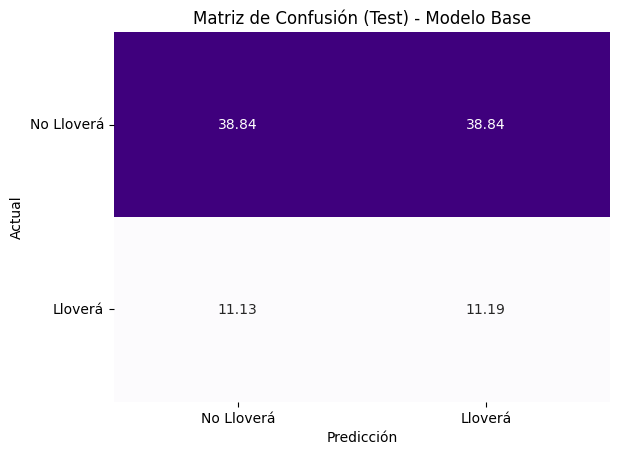

In [46]:
#matriz de confusión del modelo base
conf_matrix_base = confusion_matrix(y_test, y_pred_base, labels=['No', 'Yes'])
conf_matrix_base_percent = conf_matrix_base / conf_matrix_base.sum() * 100

# Graficar la matriz de confusión del modelo base
plt.figure()
sns.heatmap(conf_matrix_base_percent, annot=True, fmt=".2f", cmap="Purples", cbar=False)
plt.title("Matriz de Confusión (Test) - Modelo Base")
plt.xlabel("Predicción")
plt.ylabel("Actual")
plt.xticks(ticks=[0.5, 1.5], labels=['No Lloverá', 'Lloverá'])
plt.yticks(ticks=[0.5, 1.5], labels=['No Lloverá', 'Lloverá'], rotation=0)
plt.show()

#### Curva ROC

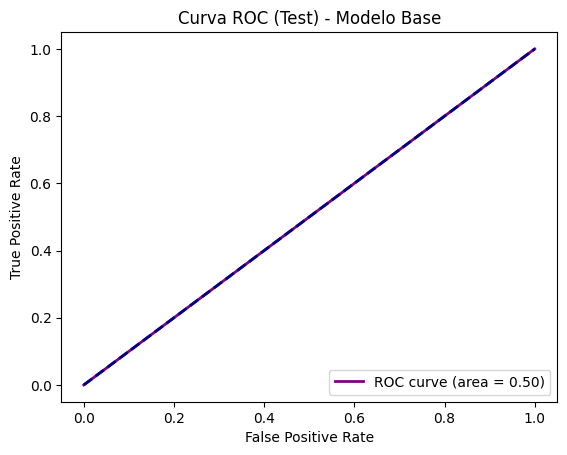

In [47]:
# curva ROC del modelo base

fpr_base, tpr_base, thresholds_base = roc_curve(y_test.map({'No': 0, 'Yes': 1}), modelo_base.predict_proba(X_test_final)[:, 1])
roc_auc_base = auc(fpr_base, tpr_base)
# Graficar la curva ROC del modelo base
plt.figure()
plt.plot(fpr_base, tpr_base, color='purple', lw=2, label=f'ROC curve (area = {roc_auc_base:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC (Test) - Modelo Base')
plt.legend(loc="lower right")
plt.show()

### Optimización de la selección de hiperparámetros:

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Creamos el pipeline primero escalamos y luego entrenar modelo
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver='liblinear', max_iter=500))
])

# Definimos los hiperparámetros a optimizar
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],  # Inverso de L2
    'logreg__penalty': ['l1', 'l2']        # Lasso o Ridge 
}

# Configuramos Grid Search con validación cruzada de 5 folds
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='accuracy',   
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Entrenamos con validación cruzada
grid_search.fit(X_train_full, y_train)

# Mostramos los mejores parámetros y el score asociado
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor precisión en validación cruzada:", grid_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores hiperparámetros encontrados: {'logreg__C': 0.01, 'logreg__penalty': 'l1'}
Mejor precisión en validación cruzada: 0.8452713546222578


Usamos GridSearchCV para encontrar los mejores hiperparámetros de Logistic Regression. Para ello, optimizamos el accuracy con una validación cruzada de 5 folds. El mejor modelo resultó con C = 0.01 que indica una fuerte regularización y penalty = 'l1' de Lasso, que implica una penalización más fuerte, que mejora la generalización.

Usamos un Pipeline para escalar las variables con standardScaler y encadenarlas al modelo, así la estandarización se aplica en cada fold de manera correcta evitando fugas de información. Escalamos porque sin escalado, las penalizaciones podrían afectar de forma desbalanceada a las features.

Los hiperparámetros optimizados fueron:

C: El inverso de la fuerza de la regularización. 

penalty: Se comparara L1  y L2. La validación cruzada favoreció L1, indicando que modelos con pocos coeficientes relevantesfuncionan mejor en este conjunto de datos.

Al final, el mejor modelo tuvo un accuracy de validación cruzada del 84.52%, mostrando que se pudo encontrar una configuración que supera a la regresión logística estándar sin regularización ni ajuste fino.

### Implementar explicabilidad de los modelos

In [49]:
# Crear el explainer para el modelo (depende del tipo de modelo)
explainer = shap.Explainer(modelo, X_test_final)

# Calcular valores SHAP para el conjunto de test
shap_values = explainer(X_test_final)

### AutoML con PyCaret: 

In [ ]:
#!pip install pycaret

# Importar PyCaret 
from pycaret.classification import *

# dataframe de entrenamiento con X e y unidos
df_train = X_train_full.copy()
df_train['target'] = y_train

# configurar/inicializar entorno de PyCaret
setup(data=df_train, 
      target='target', 
      session_id=123, 
      normalize=True, 
      verbose=False, 
      use_gpu=False)

# Compararamos todos los modelos de clasificación disponibles
best_model = compare_models()

# detalles de los mejores modelos
print(best_model)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8575,0.8881,0.8575,0.8498,0.8487,0.5456,0.5569,0.9970
rf,Random Forest Classifier,0.8563,0.8856,0.8563,0.8488,0.8449,0.5301,0.5476,4.2720
et,Extra Trees Classifier,0.8528,0.8816,0.8528,0.8447,0.8409,0.5179,0.5356,5.0120
gbc,Gradient Boosting Classifier,0.8516,0.8778,0.8516,0.8428,0.8412,0.5213,0.5348,6.9730
lr,Logistic Regression,0.8459,0.8719,0.8459,0.8362,0.8361,0.5073,0.5183,0.9700
ada,Ada Boost Classifier,0.8445,0.8665,0.8445,0.8345,0.8341,0.5003,0.5124,1.6420
lda,Linear Discriminant Analysis,0.8443,0.8694,0.8443,0.8348,0.8355,0.5073,0.5163,0.3600
ridge,Ridge Classifier,0.8435,0.8694,0.8435,0.8337,0.8290,0.4796,0.5005,0.2070
svm,SVM - Linear Kernel,0.8381,0.8578,0.8381,0.8275,0.8267,0.4777,0.4908,0.4190
knn,K Neighbors Classifier,0.8164,0.7954,0.8164,0.8009,0.8029,0.4044,0.4161,2.6440


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


Se puede observar que el mejor modelo obtenido es Light Gradient Boosting Machine (LightGBM) ya que logró el mejor rendimiento en todas las métricas vistas en el proyecto. Tiene un Accuracy de 0.8575 siendo la más alta del ranking, al igual que:

- AUC: 0.8981
- Recall y Precision: ambas en torno a 0.85, lo que indica un buen equilibrio entre la cantidad de positivos detectados y la precisión con la que lo hace
- F1 Score: 0.8487
- Kappa y MCC: también son los más altos, lo que refuerza que el modelo no solo tiene buena precisión sino también un acuerdo general superior considerando clases desbalanceadas

Se observa entonces que el modelo elegido por PyCaret supera al elegido en el proyecto (Logistic Regression) mejorando las métricas.

También se puede notar que el tiempo de entrenamiento de LightGBM es super bajo comparado con otros modelos lo que lo caracteriza como eficiente.

En conclusión PyCaret identificó el mejor modelo de manera automática sin necesidad de hacer una prueba manual de cada uno, lo cual ahorra tiempo y permite hacer un análisis más exhaustivo de más modelos que tal vez no habrían sido probados y eran mejores. 